In [1]:
#This project has been done on Google colab
#data mounted from google drive. You can change path to local files to run it locally
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime 
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler 
import sys
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from fbprophet import Prophet
from datetime import timedelta  
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor

# Loading Data

First we load all the data from CSV files into pandas dataframe. We load data for each house into seperate pandas dataframes. 

In [0]:
#Load all data into dataframes
#Please change filepath to your own file path while running
filepath = "/content/drive/My Drive"
homebpowerdata=pd.read_csv(filepath + "/data/Home B - 2014/HomeB-meter1_2014.csv")
homecpowerdata=pd.read_csv(filepath + "/data/Home C -2015/HomeC-meter1_2015.csv")
homefpowerdata=pd.read_csv(filepath + "/data/Home F - 2016/HomeF-meter3_2016.csv")

homebweatherdata=pd.read_csv("/content/drive/My Drive/data/Home B - 2014/homeB2014.csv")
homecweatherdata=pd.read_csv("/content/drive/My Drive/data/Home C -2015/homeC2015.csv")
homefweatherdata=pd.read_csv("/content/drive/My Drive/data/Home F - 2016/homeF2016.csv")

homebpowerdf = pd.DataFrame(homebpowerdata)
homecpowerdf = pd.DataFrame(homecpowerdata)
homefpowerdf = pd.DataFrame(homefpowerdata)

homebweatherdf = pd.DataFrame(homebweatherdata)
homecweatherdf = pd.DataFrame(homecweatherdata)
homefweatherdf = pd.DataFrame(homefweatherdata)

models=[]
hbhourlymae=[]
hchourlymae=[]
hfhourlymae=[]
hbdailymae=[]
hcdailymae=[]
hfdailymae=[]

In [0]:
#Convert Date column to a datetime object
homebpowerdf['Date & Time']= pd.to_datetime(homebpowerdf['Date & Time']) 
homecpowerdf['Date & Time']= pd.to_datetime(homecpowerdf['Date & Time']) 
homefpowerdf['Date & Time']= pd.to_datetime(homefpowerdf['Date & Time']) 

In [5]:
homebweatherdata.describe() 

,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,7290.000000,8.760000e+03,8760.00000,8760.000000,8760.000000,8760.000000
mean,48.062076,0.682888,9.025791,45.289160,1016.450749,6.534568,0.137971,1.404319e+09,204.46347,0.003761,37.072056,0.066771
std,19.694743,0.188763,1.859263,22.860668,7.903670,3.884500,0.212384,9.104179e+06,106.57823,0.015565,20.257221,0.183459
min,-10.070000,0.140000,0.320000,-18.280000,979.980000,0.030000,0.000000,1.388552e+09,0.00000,0.000000,-15.870000,0.000000
25%,33.165000,0.530000,9.040000,27.967500,1011.530000,3.630000,0.000000,1.396436e+09,150.00000,0.000000,23.425000,0.000000
50%,49.220000,0.710000,9.970000,47.360000,1016.430000,5.850000,0.060000,1.404319e+09,210.00000,0.000000,38.510000,0.000000
75%,63.832500,0.860000,10.000000,63.832500,1021.310000,8.692500,0.200000,1.412202e+09,297.00000,0.000000,54.302500,0.000000
max,89.460000,0.960000,10.000000,97.520000,1042.400000,24.750000,1.000000,1.420085e+09,359.00000,0.355700,72.880000,0.870000


We have 8760 = 365 x 24 rows for weather, which is total hours in a year. So we have data for a whole year with each row representing an hour duration

Now we merge weather data with power usage data. We will use weather parameters in our prediction models, specifically linear regression and random forests

In [0]:
#Merge weather data

def MergeData(powerdf,weatherdf,currentyear):
  #building time features
  currenttime = datetime.datetime(currentyear,1,1,0,0,0) 
  datearr = []
  for index, row in weatherdf.iterrows():
    datearr.append(currenttime)
    currenttime = currenttime + timedelta(hours=1) #add delta of one hour to each iteration
  weatherdf['Date'] = datearr
  powerdf['Date']= powerdf["Date & Time"].dt.floor(freq = 'H') 
  #homebpowerdf.head()
  powerdf = powerdf.merge(weatherdf, on="Date", how = 'left')  #merge with modified weather data on date
  powerdf = powerdf.drop('Date', 1) #drop redundant column
  return powerdf

powerdf =MergeData(homebpowerdf,homebweatherdata,2014)
homebpowerdf = powerdf
powerdf =MergeData(homecpowerdf,homecweatherdata,2015)
homecpowerdf = powerdf
powerdf =MergeData(homefpowerdf,homefweatherdata,2016)
homefpowerdf = powerdf

In [7]:
homebpowerdf.head()

,Date & Time,use [kW],gen [kW],Grid [kW],AC [kW],Furnace [kW],Cellar Lights [kW],Washer [kW],First Floor lights [kW],Utility Rm + Basement Bath [kW],Garage outlets [kW],MBed + KBed outlets [kW],Dryer + egauge [kW],Panel GFI (central vac) [kW],Home Office (R) [kW],Dining room (R) [kW],Microwave (R) [kW],Fridge (R) [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 00:00:00,0.304439,0.0,0.304439,0.000058,0.009531,0.005336,0.000126,0.011175,0.003836,0.004836,0.002132,0.000009,0.007159,0.063666,0.004299,0.004733,0.042589,20.31,clear-night,0.47,10.0,Clear,7.74,1023.25,12.65,0.0,1388552400,283,0.0,3.30,0.0
1,2014-01-01 00:30:00,0.656771,0.0,0.656771,0.001534,0.364338,0.005522,0.000043,0.003514,0.003512,0.004888,0.002137,0.000107,0.007221,0.064698,0.003589,0.004445,0.096008,20.31,clear-night,0.47,10.0,Clear,7.74,1023.25,12.65,0.0,1388552400,283,0.0,3.30,0.0
2,2014-01-01 01:00:00,0.612895,0.0,0.612895,0.001847,0.417989,0.005504,0.000044,0.003528,0.003484,0.004929,0.002052,0.000170,0.007197,0.065109,0.003522,0.004396,0.025928,19.22,clear-night,0.48,10.0,Clear,7.89,1023.21,9.99,0.0,1388556000,283,0.0,2.69,0.0
3,2014-01-01 01:30:00,0.683979,0.0,0.683979,0.001744,0.410653,0.005556,0.000059,0.003499,0.003476,0.004911,0.002068,0.000121,0.007236,0.065032,0.003404,0.004262,0.105472,19.22,clear-night,0.48,10.0,Clear,7.89,1023.21,9.99,0.0,1388556000,283,0.0,2.69,0.0
4,2014-01-01 02:00:00,0.197809,0.0,0.197809,0.000030,0.017152,0.005302,0.000119,0.003694,0.003865,0.004876,0.002087,0.000052,0.007133,0.062451,0.003915,0.004407,0.016798,18.10,clear-night,0.52,10.0,Clear,8.11,1024.25,7.76,0.0,1388559600,255,0.0,3.42,0.0


# Preprocessing and Analysis 

For a given timeslot, we have to predict the load demand in next hour and the next day for each household. To make this task easier, we are creating two different dataframes for each household. The first is data rows grouped on hours to predict power usage for the next hour, and the second dataframe is data rows grouped by days, to predict the power usage for the next day

In [0]:
#create dataframes with hour based groups
homebhourlydf = homebpowerdf.copy()
homebhourlydf["Date & Time"]= homebhourlydf["Date & Time"].dt.floor(freq = 'H')
homebhourlydf= homebhourlydf.groupby("Date & Time").sum().reset_index()

homechourlydf = homecpowerdf.copy()
homechourlydf["Date & Time"]= homechourlydf["Date & Time"].dt.floor(freq = 'H')
homechourlydf= homechourlydf.groupby("Date & Time").sum().reset_index()

homefhourlydf = homefpowerdf.copy()
homefhourlydf["Date & Time"]= homefhourlydf["Date & Time"].dt.floor(freq = 'H')
homefhourlydf= homefhourlydf.groupby("Date & Time").sum().reset_index()

In [9]:
#create dataframes with day based groups
homebdailydf = homebpowerdf.copy()
homebdailydf["Date & Time"]= homebdailydf["Date & Time"].dt.floor(freq = 'D')
homebdailydf= homebdailydf.groupby("Date & Time").sum().reset_index()

homecdailydf = homecpowerdf.copy()
homecdailydf["Date & Time"]= homecdailydf["Date & Time"].dt.floor(freq = 'D')
homecdailydf= homecdailydf.groupby("Date & Time").sum().reset_index()
homecdailydf.head()

homefdailydf = homefpowerdf.copy()
homefdailydf["Date & Time"]= homefdailydf["Date & Time"].dt.floor(freq = 'D')
homefdailydf= homefdailydf.groupby("Date & Time").sum().reset_index()
homefdailydf.head()

,Date & Time,Usage [kW],Generation [kW],Net_Meter [kW],Volt [kW],Garage_E [kW],Garage_W [kW],Phase_A [kW],Phase_B [kW],Solar [kW],temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,2016-01-01,2389.825167,434.905650,2275.905717,719.561400,0.739033,0.951383,1360.178600,1029.646567,434.905650,50736.0,902.4,14119.8,42004.8,1461020.4,10728.0,255.0,2090398752000,381900,0.132,34196.4,2.4
1,2016-01-02,1427.899933,1743.282517,2368.395850,32.293400,0.038833,0.510800,760.068650,667.831283,1743.282517,46292.4,816.6,14391.0,36412.8,1460810.4,11176.8,264.6,2090523168000,368640,0.000,26473.8,0.0
2,2016-01-03,1563.034550,1062.297650,1858.140033,161.129334,0.170500,0.581550,745.949100,817.085450,1062.297650,47995.8,900.6,14380.2,38935.8,1453288.2,10573.2,186.0,2090647584000,328140,0.000,31278.0,0.0
3,2016-01-04,2610.471967,1148.176633,3292.872400,969.680533,0.994867,1.104600,1247.334067,1363.137900,1148.176633,30150.6,828.6,14235.6,12865.2,1465759.2,17388.6,193.8,2090772000000,420480,0.000,11693.4,0.0
4,2016-01-05,2890.258183,2356.093583,4116.747600,951.455400,0.980050,1.097817,1269.920700,1620.337483,2356.093583,18243.6,763.8,14388.6,6337.8,1489638.6,8725.8,3.0,2090896416000,326160,0.000,-2820.6,0.0


# Visualization

We visualize a few plots and distributions to see if we can find any interesting pattern in the data

Text(0, 0.5, 'Daily power usage: House F')

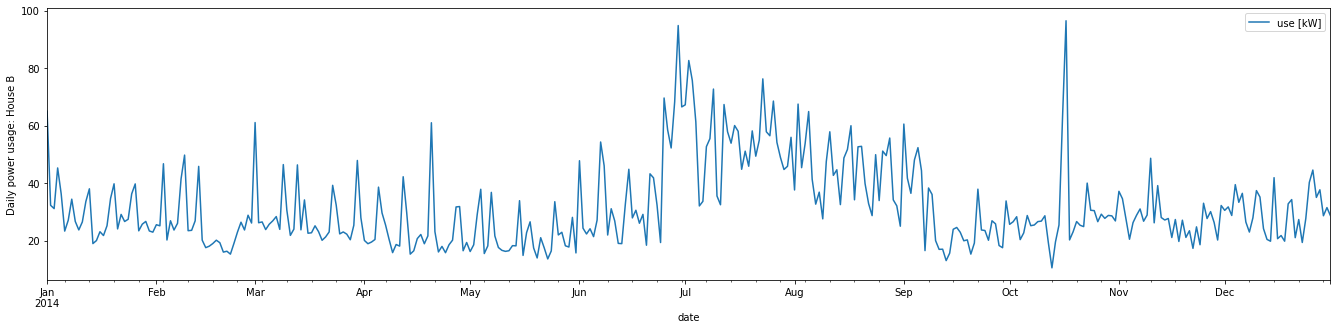

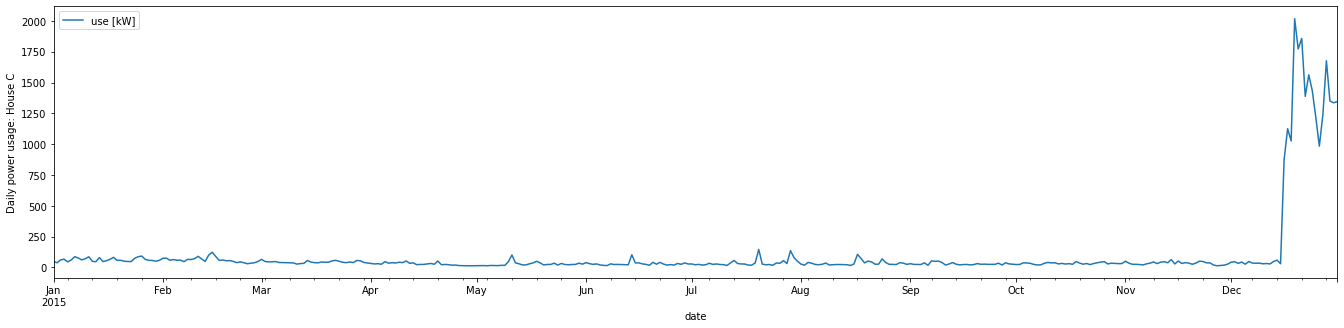

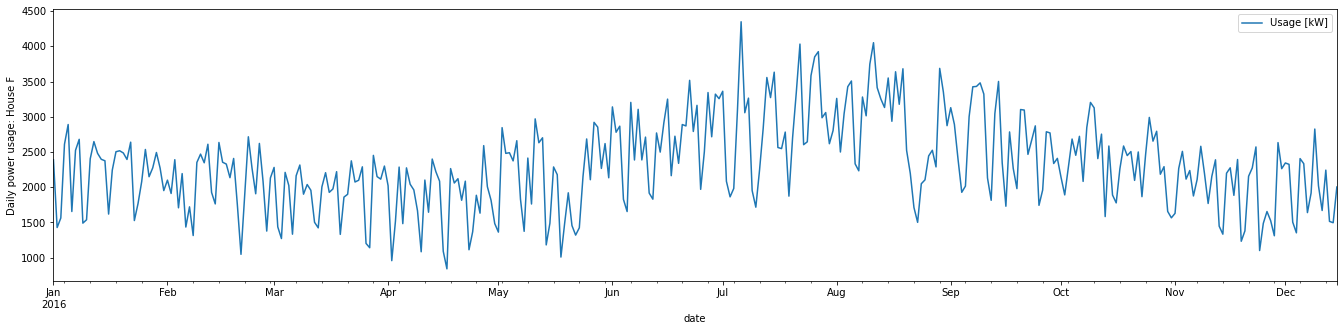

In [10]:
#plotting daily power usage wrt time
pd.plotting.register_matplotlib_converters()
ax = homebdailydf.plot(y='use [kW]',x='Date & Time',figsize=(23,5))
ax.set_xlabel("date")
ax.set_ylabel("Daily power usage: House B")

ax = homecdailydf.plot(y='use [kW]',x='Date & Time',figsize=(23,5))
ax.set_xlabel("date")
ax.set_ylabel("Daily power usage: House C")

ax = homefdailydf.plot(y='Usage [kW]',x='Date & Time',figsize=(23,5))
ax.set_xlabel("date")
ax.set_ylabel("Daily power usage: House F")

From the plots above, we can see that there is a sudden increase in House C's power demand for the month of December. We have to take care of this while building our prediction models. We can also see that the data follows a time series pattern. We can also see the power usage is relatively higher for the months of summer (starting june to september). 

Text(0, 0.5, 'Hourly power usage: House F')

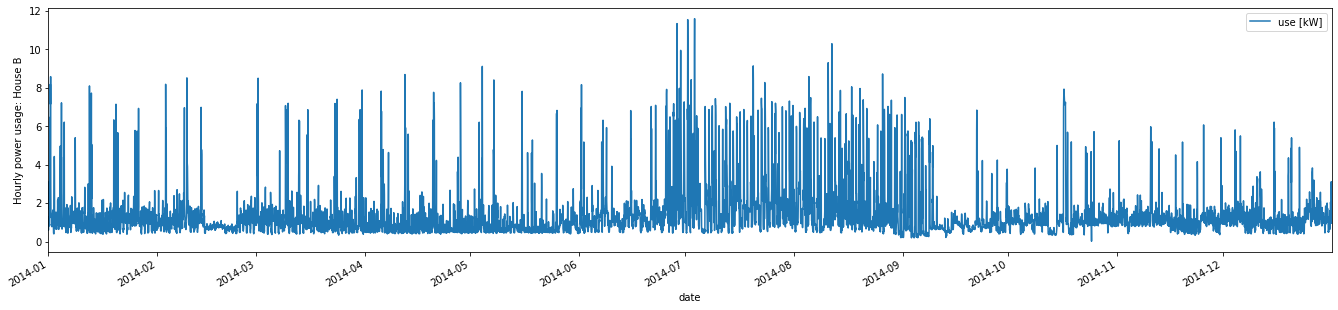

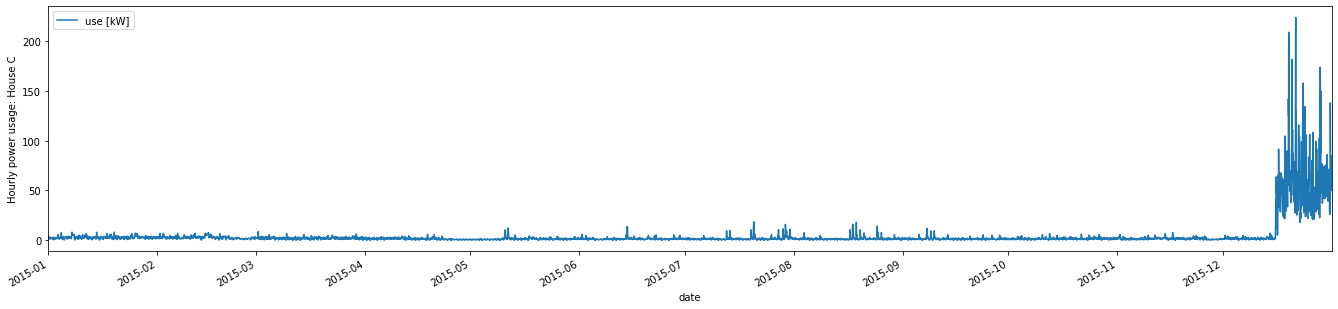

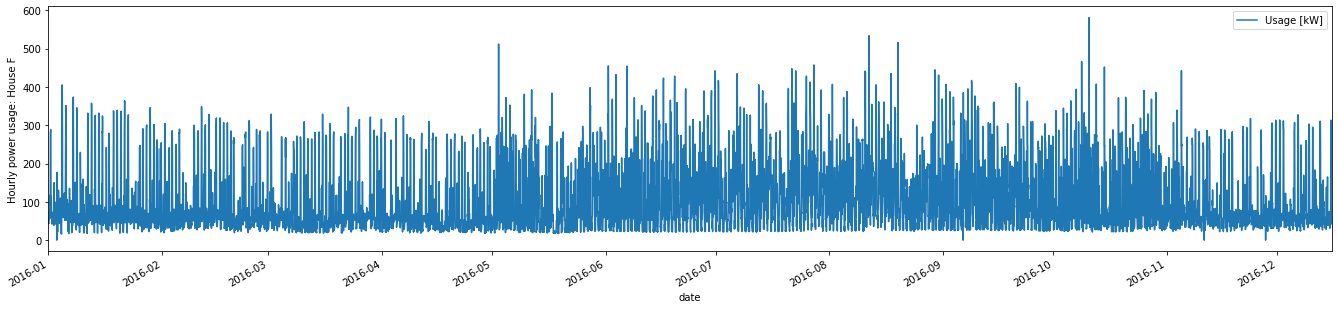

In [11]:
#plotting hourly power usage wrt time
ax = homebhourlydf.plot(y='use [kW]',x='Date & Time',figsize=(23,5))
ax.set_xlabel("date")
ax.set_ylabel("Hourly power usage: House B")

ax = homechourlydf.plot(y='use [kW]',x='Date & Time',figsize=(23,5))
ax.set_xlabel("date")
ax.set_ylabel("Hourly power usage: House C")

ax = homefhourlydf.plot(y='Usage [kW]',x='Date & Time',figsize=(23,5))
ax.set_xlabel("date")
ax.set_ylabel("Hourly power usage: House F")

Even through these data plots, we can see that the data follows a time series pattern. Moreover, the spikes have become more prominent. We can infer that the spikes are for periods during daytime whereas power usage reduces during the hours at night.

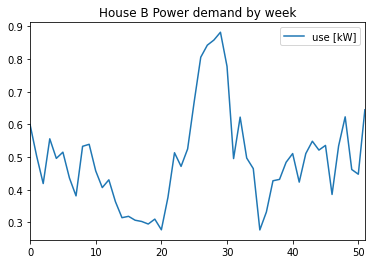

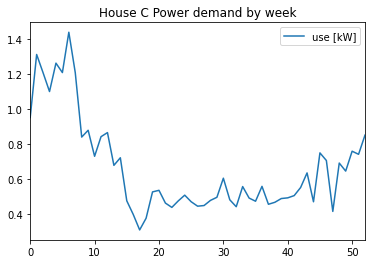

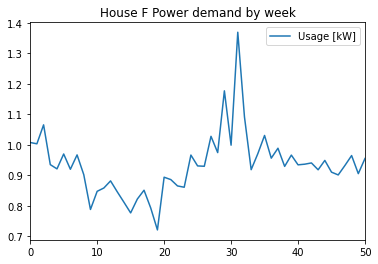

In [12]:
#Power demand by week
plotdf= homebpowerdf.groupby(homebpowerdf["Date & Time"].dt.week)['use [kW]'].median().reset_index() #We take median and not mean because of the outliers
plotdf.plot(y='use [kW]',title='House B Power demand by week')
plotdf= homecpowerdf.groupby(homecpowerdf["Date & Time"].dt.week)['use [kW]'].median().reset_index() #We take median and not mean because of the outliers
plotdf.plot(y='use [kW]',title='House C Power demand by week')
plotdf= homefpowerdf.groupby(homefpowerdf["Date & Time"].dt.week)['Usage [kW]'].median().reset_index() #We take median and not mean because of the outliers
plotdf.plot(y='Usage [kW]',title='House F Power demand by week')

Even in these graphs, we can clearly see that the power usage is generally higher for the weeks of summer for house B and F, whereas it is much higher for the weeks of winter for house C.

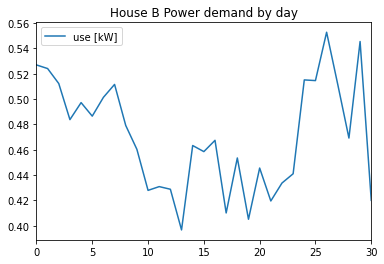

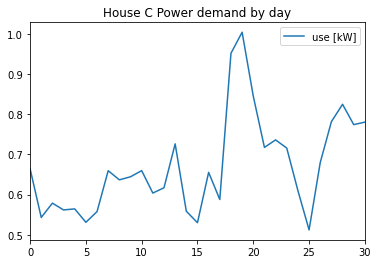

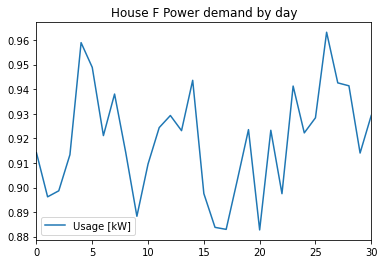

In [13]:
#Power Demand by days of month
plotdf= homebpowerdf.groupby(homebpowerdf["Date & Time"].dt.day)['use [kW]'].median().reset_index() #We take median and not mean because of the outliers
plotdf.plot(y='use [kW]',title='House B Power demand by day')
plotdf= homecpowerdf.groupby(homecpowerdf["Date & Time"].dt.day)['use [kW]'].median().reset_index() #We take median and not mean because of the outliers
plotdf.plot(y='use [kW]',title='House C Power demand by day')
plotdf= homefpowerdf.groupby(homefpowerdf["Date & Time"].dt.day)['Usage [kW]'].median().reset_index() #We take median and not mean because of the outliers
plotdf.plot(y='Usage [kW]',title='House F Power demand by day')

We can see a rough periodic pattern in days of a month

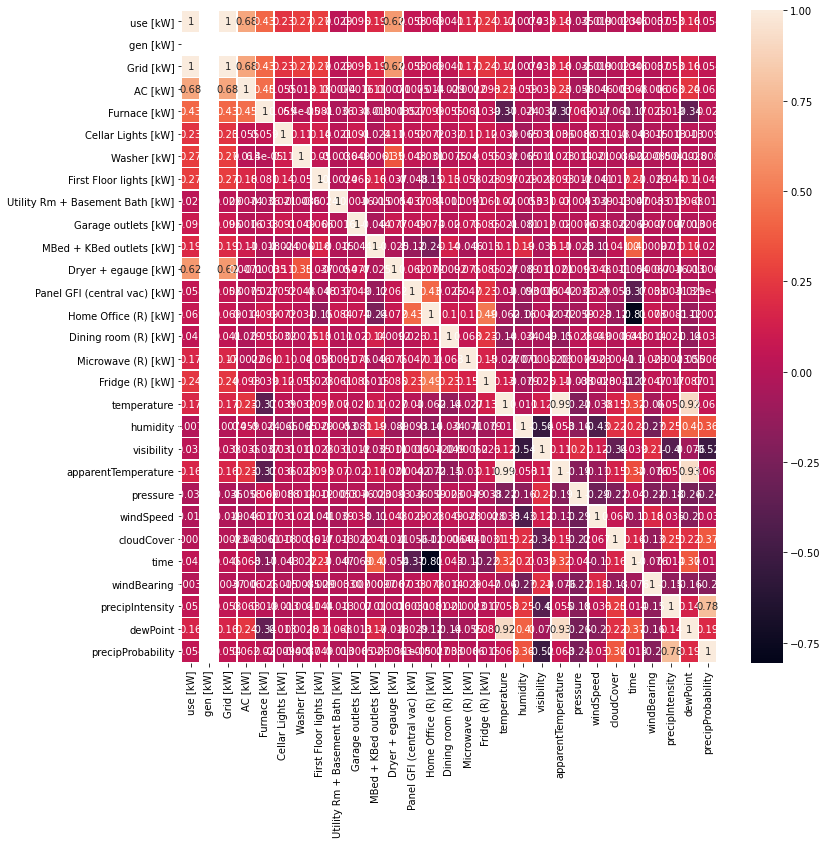

In [14]:
#Correlation matrix between columns to see strongly correlated columns
corr_traindf=homebpowerdf.corr(method='pearson')
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_traindf, annot=True, linewidths=.5)
plt.show()

# Prediction Models

Since the data follows a time-series pattern, I have tried a few time series models like ARIMA, SARIMA, Facebook's Prophet to see how effective the time-series predictions are. In addition to this, traditional models like linear regression and random forests are also implemented. Mean absolute error is used to compare efficiency of various models, and data is roughly divided into training (60%), validation (20%) and test (20%) sets respectively. We use the naive model as the baseline model

# Naive Model

For our baseline model, we are using the last observed value as the prediction for all steps into the future. We are then finding the mean absolute error by comparing these results with actual values.

In [15]:
#naive model for hourly and daily prediction
models.append("Naive")

def Naive(usagearr):
  usagearr_scaled = preprocessing.scale(usagearr)
  lendfsplit = int(len(usagearr_scaled)*0.8)
  train = usagearr_scaled[:lendfsplit]
  test = usagearr_scaled[lendfsplit:]
  val = usagearr_scaled[len(usagearr_scaled)-1]
  testarr = np.full(len(usagearr_scaled)- lendfsplit, val) 
  #print("B:",val)
  error = mean_absolute_error(testarr, test)
  return error

print("Naive Model:")
usagearr = homebhourlydf[['use [kW]']].values
error = Naive(usagearr)
hbhourlymae.append(error)
print("Mean absolute error for house B hourly prediction:",error)

usagearr = homechourlydf[['use [kW]']].values
error = Naive(usagearr)
hchourlymae.append(error)
print("Mean absolute error for house C hourly prediction:",error)

usagearr = homefhourlydf[['Usage [kW]']].values
error = Naive(usagearr)
hfhourlymae.append(error)
print("Mean absolute error for house F hourly prediction:",error)

usagearr = homebdailydf[['use [kW]']].values
error = Naive(usagearr)
hbdailymae.append(error)
print("Mean absolute error for house B daily prediction:",error)

usagearr = homecdailydf[['use [kW]']].values
error = Naive(usagearr)
hcdailymae.append(error)
print("Mean absolute error for house C daily prediction:",error)

usagearr = homefdailydf[['Usage [kW]']].values
error = Naive(usagearr)
hfdailymae.append(error)
print("Mean absolute error for house F daily prediction:",error)


Naive Model:
Mean absolute error for house B hourly prediction: 0.32792110780319367
Mean absolute error for house C hourly prediction: 3.8564610122905325
Mean absolute error for house F hourly prediction: 0.5960008237282606
Mean absolute error for house B daily prediction: 0.34140143424445374
Mean absolute error for house C daily prediction: 3.78053940046949
Mean absolute error for house F daily prediction: 0.6638539490800054


# Linear Regression

First for each row we are assigning the next hour/day's power demand to the row as a new column "predicted" as part of our train data results (ytrain). We are then seperating data randomly from the entire dataset into training, validation and testing sets respectively using "train_test_split". We are then fitting training data to the regressor and then predicting test results using the given regressor. Finally, we calculate mean absolute error for each prediction

In [16]:
#Linear Regression
models.append("Linear Regression")

def linearregression(inputdata,house):
    inputdf = inputdata.copy()
    scaler = preprocessing.StandardScaler()
    if(house=="f"):
      inputdf[['Usage [kW]', 'temperature']] = scaler.fit_transform(inputdf[['Usage [kW]', 'temperature']])
      inputdf["predicted"] = inputdf['Usage [kW]'].shift(-1)
    else:
      inputdf[['use [kW]', 'temperature']] = scaler.fit_transform(inputdf[['use [kW]', 'temperature']])
      inputdf["predicted"] = inputdf['use [kW]'].shift(-1)
    predictiondf = inputdf["predicted"]
    #print(predictiondf.head())
    predictiondf.dropna(axis=0,inplace=True)
    inputdf = inputdf.drop('predicted', 1)
    inputdf = inputdf.drop('Date & Time', 1)
    inputdf = inputdf.drop('time', 1)
    inputdf.dropna(axis=1,inplace=True)
    inputdf = inputdf[:-1]
    x = np.array(inputdf)
    y = np.array(predictiondf)
    trainx, testx, trainy, testy = train_test_split(x,y,test_size= 0.2, random_state=0)
    lenvalidationsplit = int(len(trainx)*0.8)
    lr = LinearRegression()
    lr.fit(trainx, trainy)
    validationx = trainx[:lenvalidationsplit-1]
    validationy = trainy[:lenvalidationsplit-1]
    validationpred = lr.predict(validationx)
    validationerror= mean_absolute_error(validationy, validationpred)
    print("Validation MAE: ",validationerror)
    predicted_y = lr.predict(testx)
    error= mean_absolute_error(testy, predicted_y)
    return error

print("Linear Regression:")
error = linearregression(homebhourlydf,"b")
hbhourlymae.append(error)
print("Mean absolute error for house B hourly prediction:",error)

error = linearregression(homechourlydf,"c")
hchourlymae.append(error)
print("Mean absolute error for house C hourly prediction:",error)

error = linearregression(homefhourlydf,"f")
hfhourlymae.append(error)
print("Mean absolute error for house F hourly prediction:",error)

error = linearregression(homebdailydf,"b")
hbdailymae.append(error)
print("Mean absolute error for house B daily prediction:",error)

error = linearregression(homecdailydf,"c")
hcdailymae.append(error)
print("Mean absolute error for house C daily prediction:",error)

error = linearregression(homefdailydf,"f")
hfdailymae.append(error)
print("Mean absolute error for house F daily prediction:",error)

Linear Regression:
Validation MAE:  0.36241646090625845
Mean absolute error for house B hourly prediction: 0.3804949467581951
Validation MAE:  0.0931809650625134
Mean absolute error for house C hourly prediction: 0.09357601871768603
Validation MAE:  0.4727830026700932
Mean absolute error for house F hourly prediction: 0.4840514841473353
Validation MAE:  0.5142006915647714
Mean absolute error for house B daily prediction: 0.5231987269725168
Validation MAE:  0.0596100677457057
Mean absolute error for house C daily prediction: 0.09131009079370841
Validation MAE:  0.6321758649121746
Mean absolute error for house F daily prediction: 0.6305979777822609


# ARIMA

We have tried the Autoregressive integrated moving average (ARIMA) model for time series forecasting. The data is divided into training, validation and test sets. We are using training and validation sets to fine tune our hyperparameters, like "p" and "d" in the order component. We choose the model with least mean absolute error on the validation set. This chosen optimal model is then used for prediction of test data.

In [17]:
#ARIMA
models.append("ARIMA")

def GetBestModel(train):
  optimalp =0
  optimald = 0
  leasterror = float("inf")
  lensplit = int(len(train)*0.8)
  traindata = train[:lensplit]
  validationdata = train[lensplit:]
  for p in range(0,10):
    for d in range(0,2):
      newmodel = ARIMA(traindata, order=(p,d,0))
      model_fit = newmodel.fit(disp=0)
      ypredicted = model_fit.predict(start=lensplit+1, end=len(train)-1)
      error = mean_absolute_error(validationdata, ypredicted)
      if(error<leasterror):
        leasterror=error
        optimalp = p
        optimald = d
  return optimalp,optimald

def predict_Arima(usagearr):
  usagearr_scaled = preprocessing.scale(usagearr)
  lendfsplit = int(len(usagearr_scaled)*0.8)
  train = usagearr_scaled[:lendfsplit]
  test = usagearr_scaled[lendfsplit:]
  optimalp,optimald = GetBestModel(train)
  #print(model)
  model = ARIMA(train, order=(optimalp,optimald,0))
  model_fit = model.fit(disp=0)
  #model_fit.plot_diagnostics(figsize=(18, 8))
  #plt.show()
  y_predicted = model_fit.predict(start=lendfsplit+1, end=len(usagearr_scaled)-1)
  error = mean_absolute_error(test, y_predicted)
  return error

print("ARIMA:")
usagearr = homebhourlydf[['use [kW]']].values
error = predict_Arima(usagearr)
hbhourlymae.append(error)
print("Mean absolute error for house B hourly prediction:",error)

usagearr = homechourlydf[['use [kW]']].values
error = predict_Arima(usagearr)
hchourlymae.append(error)
print("Mean absolute error for house C hourly prediction:",error)

usagearr = homefhourlydf[['Usage [kW]']].values
error = predict_Arima(usagearr)
hfhourlymae.append(error)
print("Mean absolute error for house F hourly prediction:",error)

usagearr = homebdailydf[['use [kW]']].values
error = predict_Arima(usagearr)
hbdailymae.append(error)
print("Mean absolute error for house B daily prediction:",error)

usagearr = homecdailydf[['use [kW]']].values
error = predict_Arima(usagearr)
hcdailymae.append(error)
print("Mean absolute error for house C daily prediction:",error)

usagearr = homefdailydf[['Usage [kW]']].values
error = predict_Arima(usagearr)
hfdailymae.append(error)
print("Mean absolute error for house F daily prediction:",error)

ARIMA:
Mean absolute error for house B hourly prediction: 0.36869888459732536
Mean absolute error for house C hourly prediction: 0.9570900854809568
Mean absolute error for house F hourly prediction: 0.7352393820378684
Mean absolute error for house B daily prediction: 0.4098924258004209
Mean absolute error for house C daily prediction: 1.0641906571755064
Mean absolute error for house F daily prediction: 0.6822084360927477


# SARIMA

We have also tried the Seasonal ARIMA model for time series forecasting since from the visualizations it seems like the data has a seasonal trend. The data is again divided into training, validation and test sets. We are using training and validation sets to fine tune our hyperparameters, like "p" and "d" in the order component. We choose the model with least mean absolute error on the validation set. This chosen optimal model is then used for prediction of test data.

In [18]:
# SARIMA
models.append("SARIMA")

def GetBestModelSarima(train):
  optimalp =0
  optimald = 0
  leasterror = float("inf")
  lensplit = int(len(train)*0.8)
  traindata = train[:lensplit]
  validationdata = train[lensplit:]
  for p in range(0,10):
    for d in range(0,2):
      model_fit = sm.tsa.statespace.SARIMAX(train,order=(p,d,0)).fit()
      ypredicted = model_fit.predict(start=lensplit, end=len(train)-1)
      error = mean_absolute_error(validationdata, ypredicted)
      if(error<leasterror):
        leasterror=error
        optimalp = p
        optimald = d
  return optimalp,optimald

def SARIMA(usagearr):
  usagearr_scaled = preprocessing.scale(usagearr)
  lendfsplit = int(len(usagearr_scaled)*0.8)
  train = usagearr_scaled[:lendfsplit]
  test = usagearr_scaled[lendfsplit:]
  #testsize = len(test)
  #X_range = np.array([i for i in range(testsize)])
  p,d = GetBestModelSarima(train)
  modelfit = sm.tsa.statespace.SARIMAX(train,order=(p,d,0)).fit()
  #fit1.plot_diagnostics(figsize=(18, 8))
  #plt.show()
  y_predicted = modelfit.predict(start=lendfsplit, end=len(usagearr_scaled)-1,dynamic=True)
  error = mean_absolute_error(test, y_predicted)
  #print(test)
  #plotvalues(X_range, y_predicted,test , 0, "Actual values", "Naive model", 364)
  return error


import warnings
warnings.filterwarnings('ignore')
print("SARIMA:")
usagearr = homebhourlydf[['use [kW]']].values
error= SARIMA(usagearr)
hbhourlymae.append(error)
print("Mean absolute error for house B hourly prediction:",error)

usagearr = homechourlydf[['use [kW]']].values
error= SARIMA(usagearr)
hchourlymae.append(error)
print("Mean absolute error for house C hourly prediction:",error)

usagearr = homefhourlydf[['Usage [kW]']].values
error= SARIMA(usagearr)
hfhourlymae.append(error)
print("Mean absolute error for house F hourly prediction:",error)

usagearr = homebdailydf[['use [kW]']].values
error= SARIMA(usagearr)
hbdailymae.append(error)
print("Mean absolute error for house B daily prediction:",error)

usagearr = homecdailydf[['use [kW]']].values
error= SARIMA(usagearr)
hcdailymae.append(error)
print("Mean absolute error for house C daily prediction:",error)

usagearr = homefdailydf[['Usage [kW]']].values
error= SARIMA(usagearr)
hfdailymae.append(error)
print("Mean absolute error for house F daily prediction:",error)


SARIMA:
Mean absolute error for house B hourly prediction: 0.3431394041853273
Mean absolute error for house C hourly prediction: 0.9576967886768074
Mean absolute error for house F hourly prediction: 0.7203971263732503
Mean absolute error for house B daily prediction: 0.5052320728279925
Mean absolute error for house C daily prediction: 1.0643064235638053
Mean absolute error for house F daily prediction: 0.6593434421573777


# Facebook's Prophet

Facebook's prophet is the third time series prediction model that we have used to predict power demand. We have configured all the parameters based on the best possible model with the lowest mean absolute error among all the other models. Daily seasonality is kept enabled, since the data clearly showed periodic patterns in daily data visualizations performed above.

In [19]:
#Prophet
models.append("Prophet")

def RunProphet(inputmaindf,house,freq):
  inputdf = inputmaindf.copy()
  usagearr=None
  if(house=="f"):
    usagearr = inputdf[['Usage [kW]']].values
  else:
    usagearr = inputdf[['use [kW]']].values
  usagearr_scaled = preprocessing.scale(usagearr)
  if(house=="f"):
    inputdf['Usage [kW]'] = usagearr_scaled
  else:
    inputdf['use [kW]'] = usagearr_scaled
  
  lendfsplit = int(len(inputdf)*0.8)
  traindf = inputdf.iloc[:lendfsplit-1]
  testdf = inputdf.iloc[lendfsplit:]
  df = pd.DataFrame({"ds": traindf['Date & Time'].values})
  if(house=="f"):
    df['y'] = traindf['Usage [kW]'].values 
  else:
    df['y'] = traindf['use [kW]'].values 
  m = Prophet(daily_seasonality=True)
  m.fit(df)
  count = len(inputdf)-lendfsplit
  if(freq=="Hourly"):
    future = m.make_future_dataframe(periods=count, freq='H')
  else:
    future = m.make_future_dataframe(periods=count, freq='D')
  future = future[::][:count]
  forecast = m.predict(future)
  y_predicted = forecast[['yhat']].values 
  if(house=="f"):
    test = testdf[['Usage [kW]']].values 
  else:
    test = testdf[['use [kW]']].values 
  testingError = mean_absolute_error(test, y_predicted)
  return testingError

print("Prophet:")
import warnings
warnings.filterwarnings('ignore')
error = RunProphet(homebhourlydf,"b","hourly")
hbhourlymae.append(error)
print("Mean absolute error for house B hourly prediction:",error)

error = RunProphet(homechourlydf,"c","hourly")
hchourlymae.append(error)
print("Mean absolute error for house C hourly prediction:",error)

error = RunProphet(homefhourlydf,"f","hourly")
hfhourlymae.append(error)
print("Mean absolute error for house F hourly prediction:",error)

error = RunProphet(homebdailydf,"b","daily")
hbdailymae.append(error)
print("Mean absolute error for house B daily prediction:",error)

error = RunProphet(homecdailydf,"c","daily")
hcdailymae.append(error)
print("Mean absolute error for house C daily prediction:",error)

error = RunProphet(homefdailydf,"f","daily")
hfdailymae.append(error)
print("Mean absolute error for house F daily prediction:",error)

Prophet:


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean absolute error for house B hourly prediction: 0.3334016126228648


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean absolute error for house C hourly prediction: 0.9841863764871159


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean absolute error for house F hourly prediction: 0.599607521511739


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean absolute error for house B daily prediction: 0.3712584258135697


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Mean absolute error for house C daily prediction: 1.0909279788985289
Mean absolute error for house F daily prediction: 0.6171574322686749


# Random Forest

In this model, for each row we are assigning the next hour/day's power demand to the row as a new column "predicted" as part of our train data results (ytrain). We are then seperating data randomly from the entire dataset into training, validation and testing sets respectively using "train_test_split". We are then fitting training data to the model and then predicting test results using the given model. Finally, we calculate mean absolute error for each prediction. Optimal value of tree depth is chosen based on optimal value of mean absolute error on validation set.

In [20]:
#Random Forest
models.append("Random Forest")

def randomforest(inputdata,house):
    inputdf = inputdata.copy()
    lendfsplit = int(len(inputdf)*0.8)
    scaler = preprocessing.StandardScaler()
    if(house=="f"):
      inputdf[['Usage [kW]', 'temperature']] = scaler.fit_transform(inputdf[['Usage [kW]', 'temperature']])
      inputdf["predicted"] = inputdf['Usage [kW]'].shift(-1)
    else:
      inputdf[['use [kW]', 'temperature']] = scaler.fit_transform(inputdf[['use [kW]', 'temperature']])
      inputdf["predicted"] = inputdf['use [kW]'].shift(-1)
    predictiondf = inputdf["predicted"]
    predictiondf.dropna(axis=0,inplace=True)
    inputdf = inputdf.drop('predicted', 1)
    inputdf = inputdf.drop('Date & Time', 1)
    inputdf = inputdf.drop('time', 1)
    inputdf.dropna(axis=1,inplace=True)
    inputdf = inputdf[:-1]
    scaler = preprocessing.StandardScaler()
    x = np.array(inputdf)
    y = np.array(predictiondf)
    xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size= 0.2, random_state=0)
    regr = RandomForestRegressor(max_depth=8, random_state=0)  
    model = regr.fit(xtrain, ytrain)
    lenvalidationsplit = int(len(xtrain)*0.8)
    validationx = xtrain[:lenvalidationsplit-1]
    validationy = ytrain[:lenvalidationsplit-1]
    validationpred = regr.predict(validationx)
    validationerror= mean_absolute_error(validationy, validationpred)
    print("Validation MAE: ",validationerror)
    y_predicted = regr.predict(xtest)
    error =  mean_absolute_error(ytest, y_predicted)
    return error

print("Random Forest:")
error = randomforest(homebhourlydf,"b")
hbhourlymae.append(error)
print("Mean absolute error for house B hourly prediction:",error)

error = randomforest(homechourlydf,"c")
hchourlymae.append(error)
print("Mean absolute error for house C hourly prediction:",error)

error = randomforest(homefhourlydf,"f")
hfhourlymae.append(error)
print("Mean absolute error for house F hourly prediction:",error)

#print(homebdailydf.head())
error = randomforest(homebdailydf,"b")
hbdailymae.append(error)
print("Mean absolute error for house B daily prediction:",error)

error = randomforest(homecdailydf,"c")
hcdailymae.append(error)
print("Mean absolute error for house C daily prediction:",error)

error = randomforest(homefdailydf,"f")
hfdailymae.append(error)
print("Mean absolute error for house F daily prediction:",error)

Random Forest:
Validation MAE:  0.2745340086459736
Mean absolute error for house B hourly prediction: 0.36682562427784143
Validation MAE:  0.05737535257640331
Mean absolute error for house C hourly prediction: 0.07955585109798441
Validation MAE:  0.33352402616474874
Mean absolute error for house F hourly prediction: 0.41161051665370463
Validation MAE:  0.2709988252559252
Mean absolute error for house B daily prediction: 0.42796194803626675
Validation MAE:  0.032295745270981245
Mean absolute error for house C daily prediction: 0.08480050058304518
Validation MAE:  0.3191138693700022
Mean absolute error for house F daily prediction: 0.6549633736757711


# Final Result

In [23]:
finalcomparison = pd.DataFrame({
    'Model': models,
    'House B:Hourly': hbhourlymae,
    'House c:Hourly': hchourlymae,
    'House F:Hourly': hfhourlymae,
    'House B:Daily': hbdailymae,
    'House C:Daily': hcdailymae,
    'House F:Daily': hfdailymae,
})
finalcomparison["Mean MAE"] =finalcomparison.mean(axis = 1, numeric_only=True)
print("MEAN ABSOLUTE ERROR:")
display(finalcomparison)
#print(tabulate(finalcomparison, headers='keys'))

MEAN ABSOLUTE ERROR:


,Model,House B:Hourly,House c:Hourly,House F:Hourly,House B:Daily,House C:Daily,House F:Daily,Mean MAE
0,Naive,0.327921,3.856461,0.596001,0.341401,3.780539,0.663854,1.594363
1,Linear Regression,0.380495,0.093576,0.484051,0.523199,0.091310,0.630598,0.367205
2,ARIMA,0.368699,0.957090,0.735239,0.409892,1.064191,0.682208,0.702887
3,SARIMA,0.343139,0.957697,0.720397,0.505232,1.064306,0.659343,0.708353
4,Prophet,0.333402,0.984186,0.599608,0.371258,1.090928,0.617157,0.666090
5,Random Forest,0.366826,0.079556,0.411611,0.427962,0.084801,0.654963,0.337620


We can finally compare the mean absolute error for all our models. Since we have predicted respective hourly and daily power demands for each of the three houses seperately, we are aggregating all the mean absolute errors into one value for each model.

All of our models performed better than the baseline model. Linear regression performed well across all the three houses, but tends to overfit for house C due to sudden spurt in data values towards the end (as seen from the plot).

Among the time series prediction models (ARIMA, SARIMA, Prophet), Prophet gave us the best results. However, the mean absolute error for prophet was still far higher than random forest and linear regression. These time series models did not perform well on House C data due to sudden break of periodic trend towards the end (December).

Random forest gave us the lowest mean absolute error, and performed quite well across all the house predictions both for hourly and daily predictions.